In [1]:
"""
https://www.kaggle.com/c/bi-attrition-prediction/overview
https://www.kaggle.com/jiangzuo/hr-comma-sep
问题描述
    我们有员工的各种统计信息，以及该员工是否已经离职，统计的信息包括了（工资、出差、工作环境满意度、工作投入度、是否加班、是否升职、工资提升比例等）
    现在需要你来通过训练数据得出 员工离职预测，并给出你在测试集上的预测结果。 我们将给出课程上公开的榜单

来源：https://github.com/BackyardofAbela/EnsembleLearning/blob/master/DecisionTree.RandomForest.ipynb
"""

'\nhttps://www.kaggle.com/c/bi-attrition-prediction/overview\nhttps://www.kaggle.com/jiangzuo/hr-comma-sep\n问题描述\n    我们有员工的各种统计信息，以及该员工是否已经离职，统计的信息包括了（工资、出差、工作环境满意度、工作投入度、是否加班、是否升职、工资提升比例等）\n    现在需要你来通过训练数据得出 员工离职预测，并给出你在测试集上的预测结果。 我们将给出课程上公开的榜单\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
% matplotlib inline

In [3]:
path = './data/HR_comma_sep.csv'
data_df = pd.read_csv(path, index_col=None)
data_df.sample(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
495,0.82,0.99,4,263,6,0,1,0,technical,medium
8404,0.82,0.55,3,207,2,0,0,0,marketing,high
7526,1.00,0.56,3,182,3,0,0,0,support,medium
3619,0.99,0.49,4,270,2,0,0,0,hr,low
8358,0.49,0.80,3,227,4,1,0,0,technical,low
2017,0.41,0.84,6,191,6,0,0,0,hr,medium
940,0.92,0.92,4,245,5,0,1,0,sales,low
5938,1.00,0.59,5,182,3,1,0,0,management,medium
12567,0.10,0.97,6,282,4,0,1,0,hr,medium
8746,0.60,0.54,3,185,2,0,0,0,technical,low


In [4]:
# 检测缺失数据
data_df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

In [5]:
# 重命名
data_df = data_df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

In [7]:
# 将预测标签‘是否离职’放在第一列
front = data_df['turnover']
data_df.drop(labels=['turnover'], axis=1, inplace=True)
data_df.insert(0, 'turnover', front)
data_df.head()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


In [8]:
# 数据分析
data_df.shape

(14999, 10)

In [9]:
data_df.dtypes

turnover                 int64
satisfaction           float64
evaluation             float64
projectCount             int64
averageMonthlyHours      int64
yearsAtCompany           int64
workAccident             int64
promotion                int64
department              object
salary                  object
dtype: object

In [10]:
# 离职率
turnover_rate = data_df.turnover.value_counts() / len(data_df)
turnover_rate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

In [11]:
data_df.describe()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.238083,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268
std,0.425924,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.000000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.000000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [12]:
# 按照是否离职分组统计
turnover_summary = data_df.groupby('turnover')
turnover_summary.mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,1.000000,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,-0.061788
satisfaction,-0.388375,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,0.025605
evaluation,0.006567,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,-0.008684
projectCount,0.023787,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,-0.006064
averageMonthlyHours,0.071287,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,-0.003544
yearsAtCompany,0.144822,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433
workAccident,-0.154622,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,0.039245
promotion,-0.061788,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,1.000000


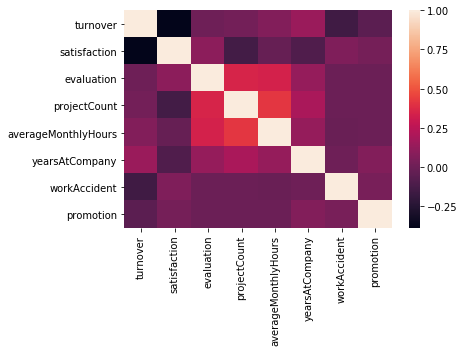

In [13]:
"""
相关性分析
"""
corr = data_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
corr

In [14]:
# 比较离职和未离职员工的满意度
emp_population = data_df['satisfaction'][data_df['turnover'] == 0].mean()
emp_turnover_satisfaction = data_df[data_df['turnover']==1]['satisfaction'].mean()
print('0 满意度: ', emp_population)
print('1 满意度: ', emp_turnover_satisfaction)

0 满意度:  0.666809590479516
1 满意度:  0.44009801176140917


In [16]:
# 满意度t-test
import scipy.stats as stats
stats.ttest_1samp(a=data_df[data_df['turnover']==1]['satisfaction'], popmean=emp_population)


Ttest_1sampResult(statistic=-51.3303486754725, pvalue=0.0)

In [19]:
degree_freedom = len(data_df[data_df['turnover']==1])
LQ = stats.t.ppf(0.025, degree_freedom) # 95%置信区间的左边界
RQ = stats.t.ppf(0.975, degree_freedom) # 95%置信区间的右边界
print('t-分布 左边界：', LQ)
print('t-分布 左边界：', RQ)

t-分布 左边界： -1.9606285215955626
t-分布 左边界： 1.9606285215955621


D:\anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'工作评价的概率密度函数 - 离职 VS 未离职')

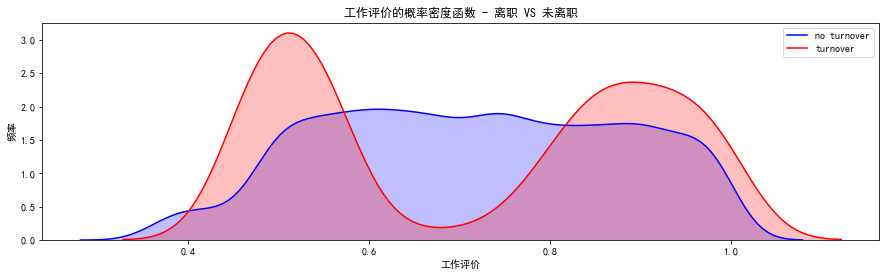

In [21]:
from matplotlib.font_manager import _rebuild
_rebuild()
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 工作评价的概率密度函数估计
fig = plt.figure(figsize=(15, 4))
ax = sns.kdeplot(data_df.loc[(data_df['turnover'] == 0), 'evaluation'], color='b', shade=True, label='no turnover')
ax = sns.kdeplot(data_df.loc[(data_df['turnover'] == 1), 'evaluation'], color='r', shade=True, label='turnover')
ax.set(xlabel='工作评价', ylabel='频率')
plt.title('工作评价的概率密度函数 - 离职 VS 未离职')

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


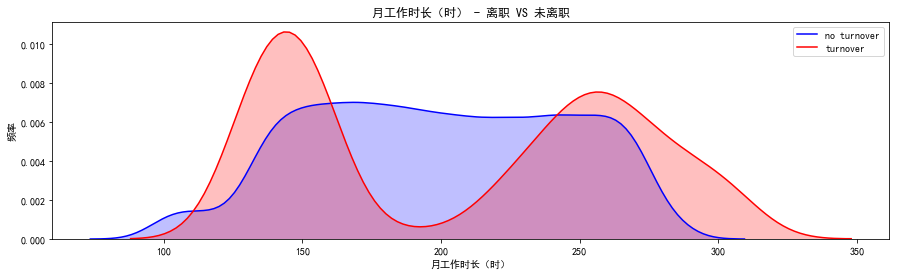

In [27]:
# 月平均工作时长概率密度函数估计
fig =  plt.figure(figsize=(15, 4))
ax = sns.kdeplot(data_df.loc[(data_df['turnover'] == 0), 'averageMonthlyHours'], color='b', shade=True, label='no turnover')
ax = sns.kdeplot(data_df.loc[(data_df['turnover'] == 1), 'averageMonthlyHours'], color='r', shade=True, label='turnover')
ax.set(xlabel='月工作时长（时）', ylabel='频率')
plt.title('月工作时长（时） - 离职 VS 未离职')
plt.show()

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


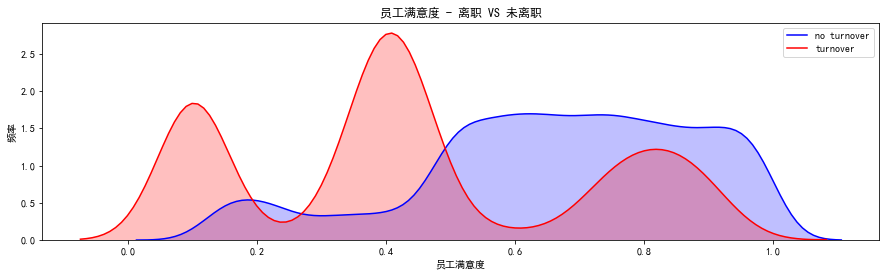

In [29]:
# 员工满意度概率密度函数估计
fig = plt.figure(figsize=(15, 4))
ax = sns.kdeplot(data_df.loc[(data_df['turnover'] == 0), 'satisfaction'], color='b', shade=True, label='no turnover')
ax = sns.kdeplot(data_df.loc[(data_df['turnover'] == 1), 'satisfaction'], color='r', shade=True, label='turnover')
ax.set(xlabel='员工满意度', ylabel='频率')
plt.title('员工满意度 - 离职 VS 未离职')
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
print(data_df.dtypes)
data_df['department'] = data_df['department'].astype('category').cat.codes
data_df['salary'] = data_df['salary'].astype('category').cat.codes

target_name = 'turnover'
x = data_df.drop('turnover', axis=1)
y = data_df[target_name]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=123, stratify=y)

data_df.head()

turnover                 int64
satisfaction           float64
evaluation             float64
projectCount             int64
averageMonthlyHours      int64
yearsAtCompany           int64
workAccident             int64
promotion                int64
department                int8
salary                    int8
dtype: object


,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,7,1
1,1,0.80,0.86,5,262,6,0,0,7,2
2,1,0.11,0.88,7,272,4,0,0,7,2
3,1,0.72,0.87,5,223,5,0,0,7,1
4,1,0.37,0.52,2,159,3,0,0,7,1


In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

In [39]:
dtree = tree.DecisionTreeClassifier(
    criterion='entropy',
    # max_depth=3, # 定义树的深度，可用于防止过拟合
    min_weight_fraction_leaf=0.01
)
dtree = dtree.fit(x_train, y_train)

# 评价指标计算
dt_roc_auc = roc_auc_score(y_test, dtree.predict(x_test))
print('dt AUC = %2.2f' % dt_roc_auc)
print(classification_report(y_test, dtree.predict(x_test)))

dt AUC = 0.93
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5714
          1       0.95      0.88      0.91      1786

avg / total       0.96      0.96      0.96      7500



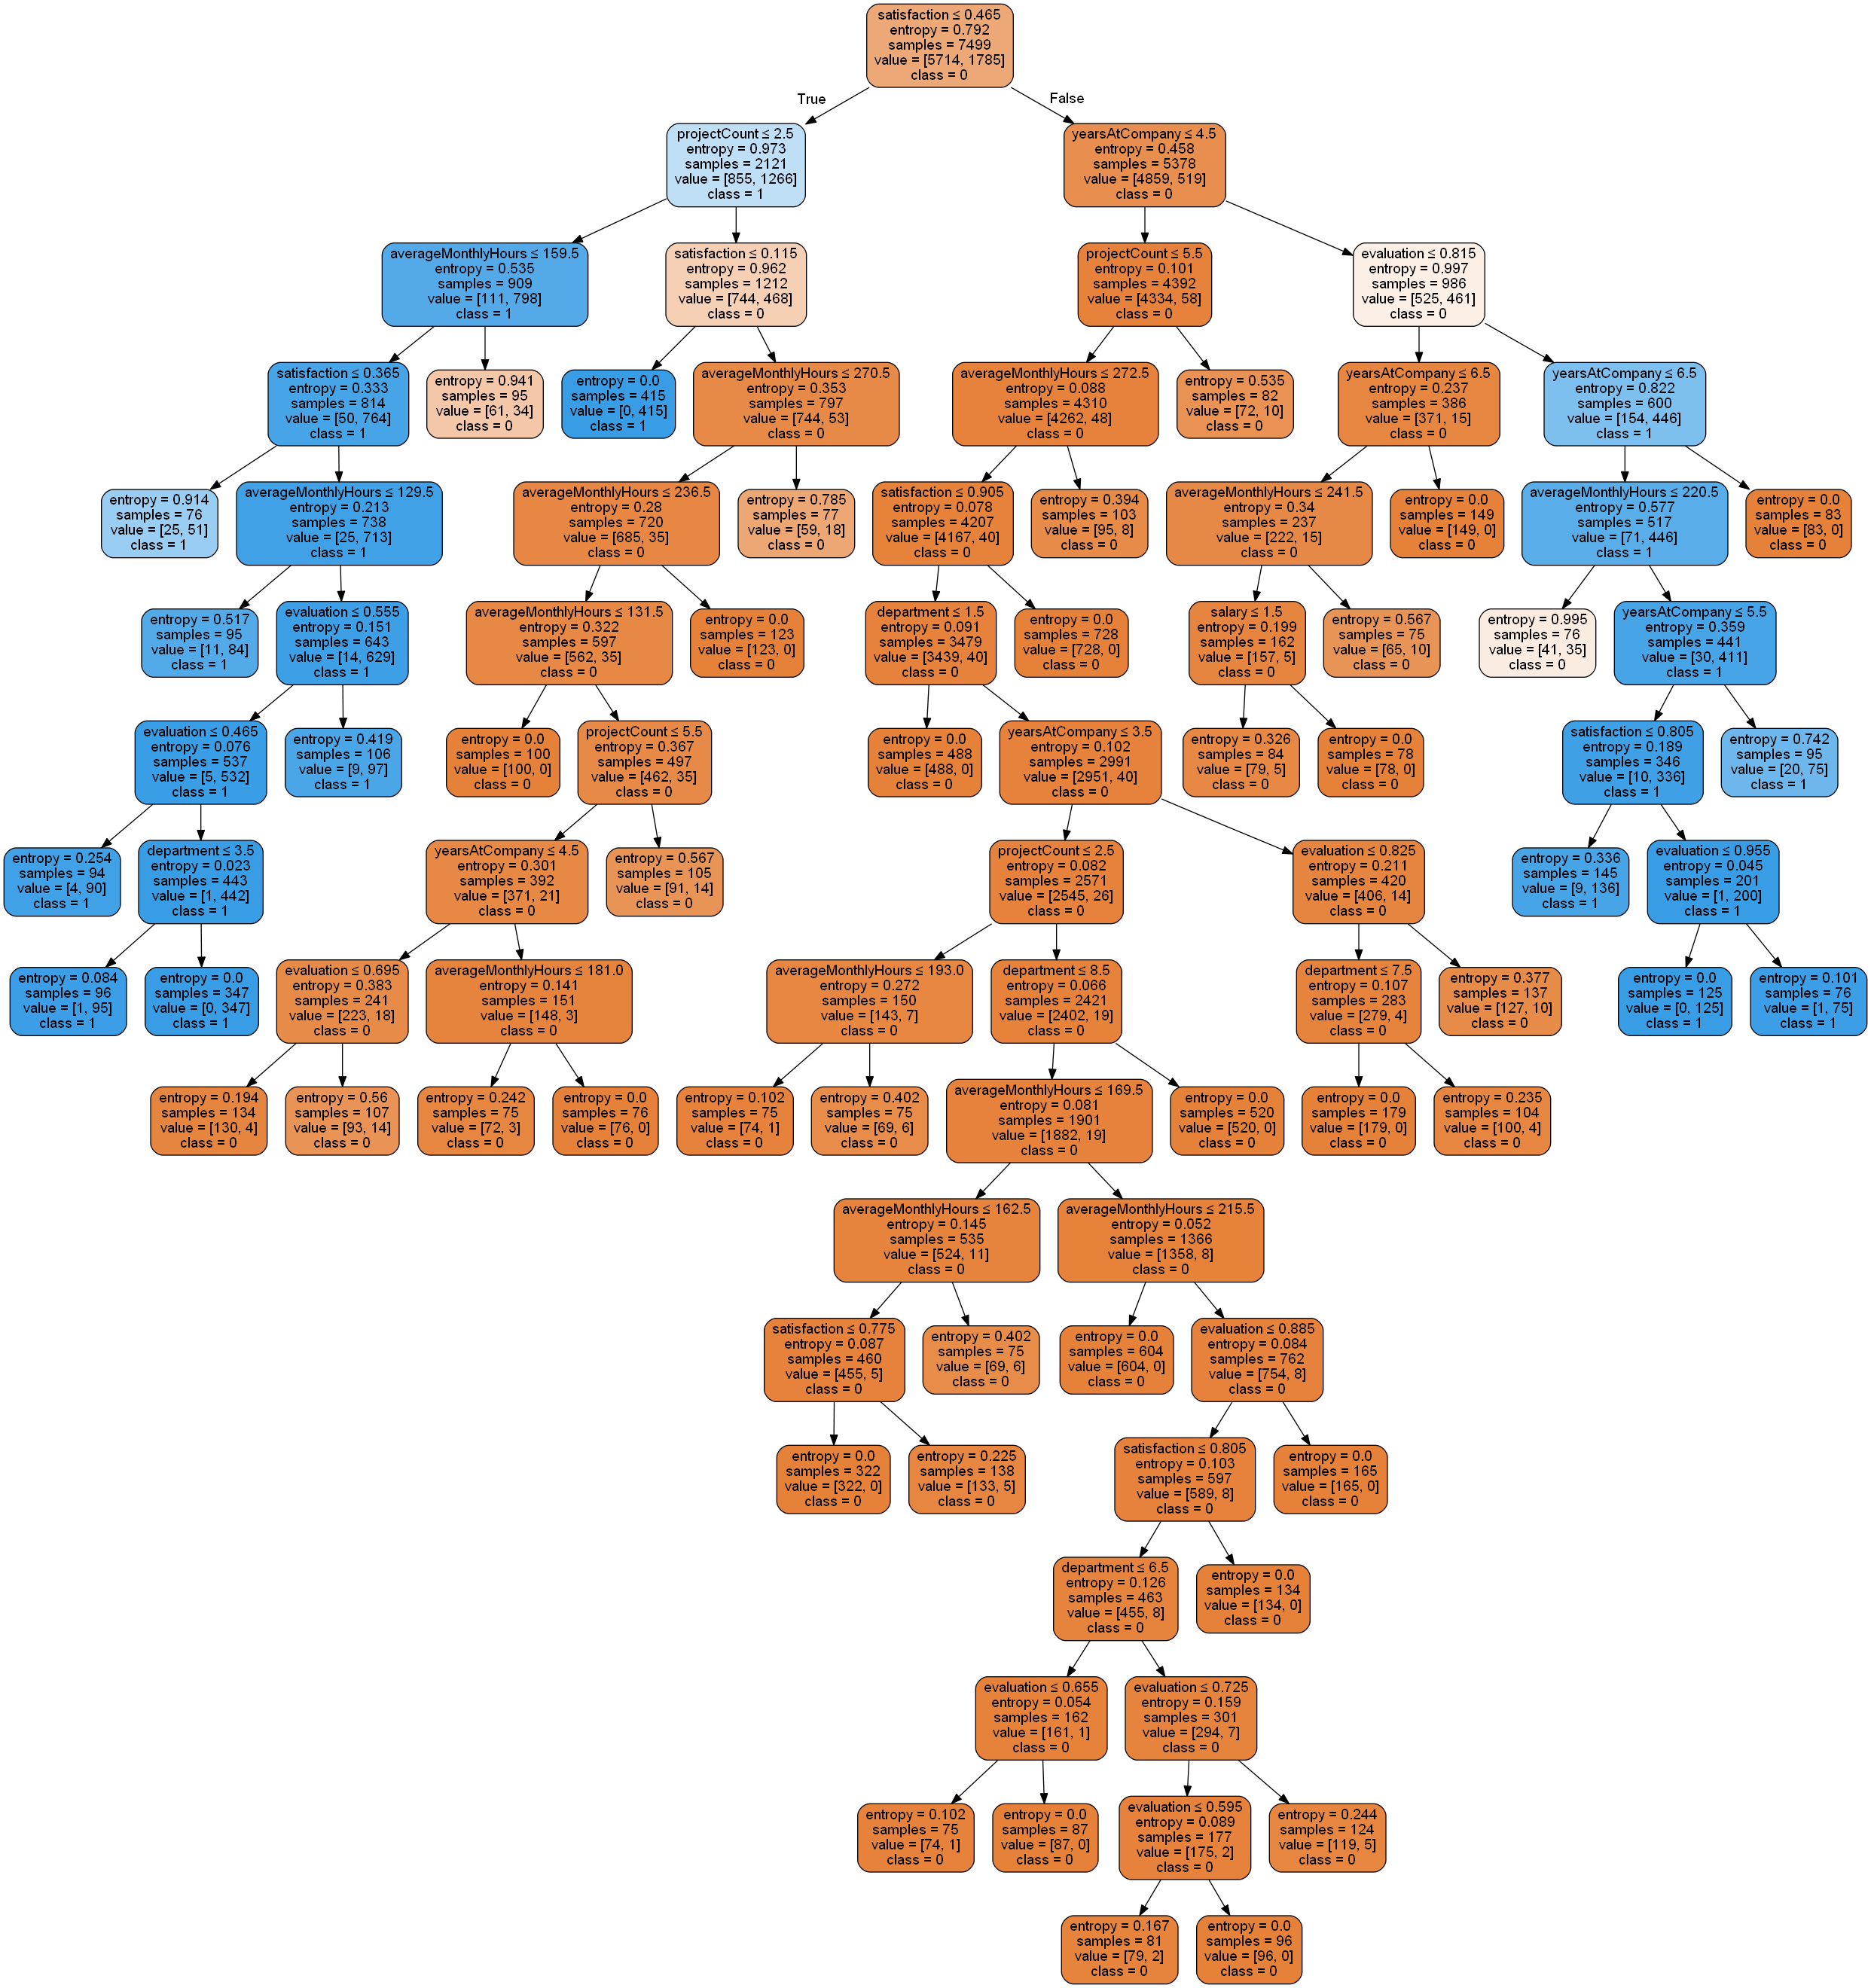

In [41]:
# 需安装GraphViz和pydotplus进行决策树的可视化
# 特征向量
feature_names = data_df.columns[1:]
# 文件缓存
dot_data = StringIO()
# 将决策树导入到dot中
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=['0','1'])
# 将生成的dot文件生成graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# 将结果存入到png文件中
graph.write_png('diabetes.png')
# 显示
Image(graph.create_png())

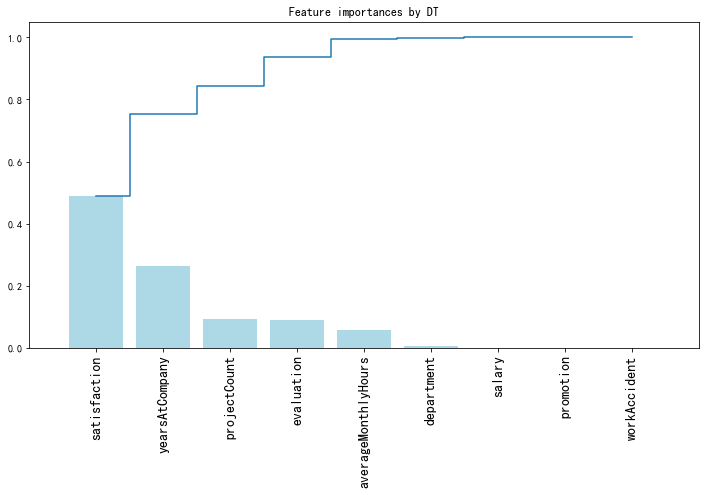

In [42]:
# 特征重要性分析
importances = dtree.feature_importances_
feature_names = data_df.drop(['turnover'], axis=1).columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature importances by DT')
plt.bar(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical', fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [44]:
# 随机森林
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=3,
    max_depth=None,
    min_samples_split=10, # 定义至少多少个样本的情况下才继续分叉
#     min_weight_fraction_leaf=0.02 # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
)
rf.fit(x_train, y_train)
rf_roc_auc = roc_auc_score(y_test, rf.predict(x_test))
print('random forest AUC = %2.2f' % rf_roc_auc)
print(classification_report(y_test, rf.predict(x_test)))

random forest AUC = 0.96
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      5714
          1       0.98      0.92      0.95      1786

avg / total       0.98      0.98      0.98      7500



0
0
1
1
2
2


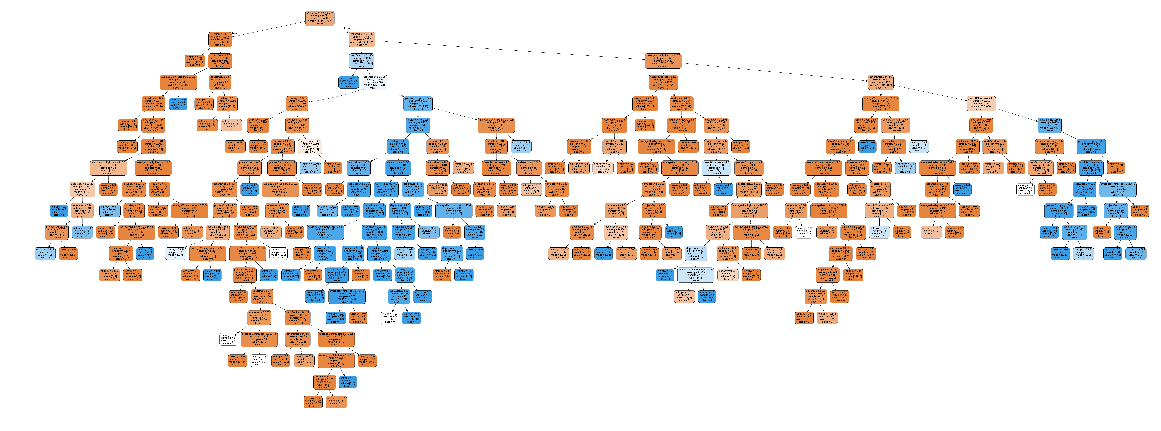

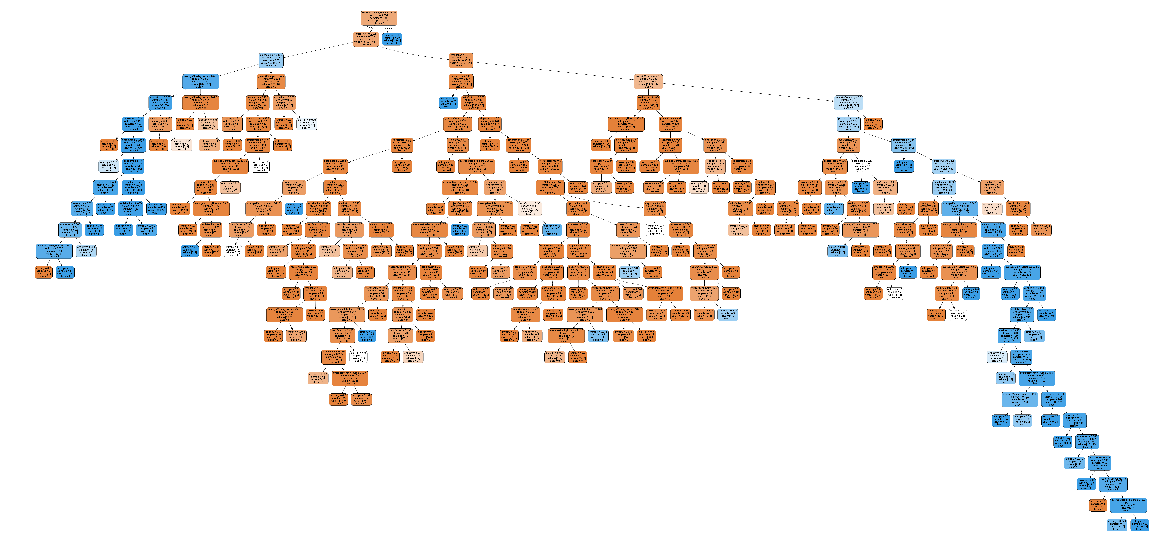

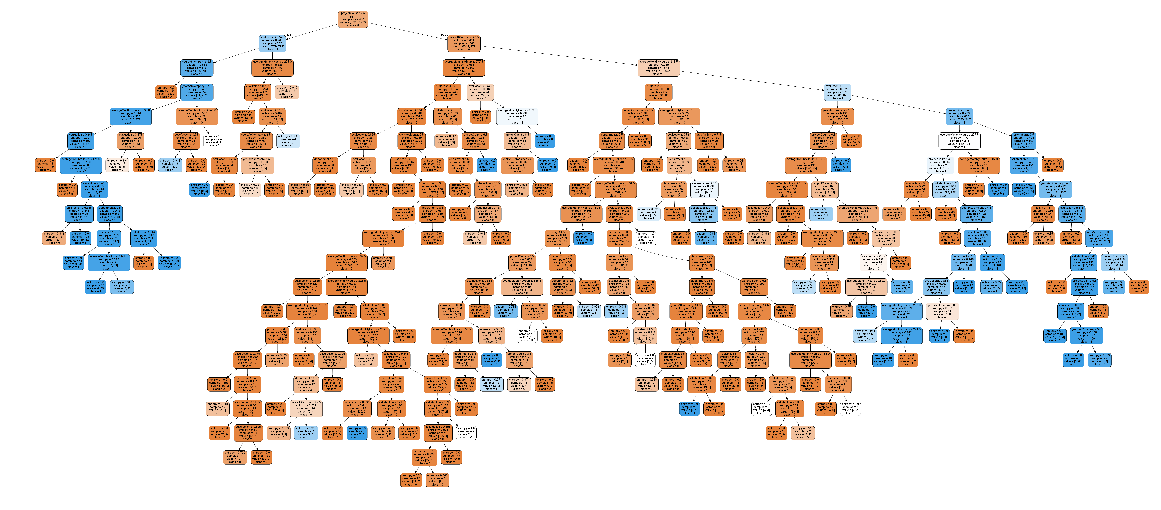

In [48]:
# 随机森林可视化
estimators = rf.estimators_
for index, model in enumerate(estimators):
    # 文件缓存
    dot_data = StringIO()
    # 将决策树导入到dot_data中
    export_graphviz(
        model, 
        out_file=dot_data,
        feature_names=data_df.columns[1:],
        class_names=['0', '1'],
        filled=True,
        rounded=True,
        special_characters=True
    )
    # 从数据中生成graph
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    # 将结果写入到png文件中
    graph.write_png('rf{}.png'.format(index))
    print(index)
    # 绘制图像
    plt.figure(figsize=(20, 20))
    print(index)
    plt.imshow(plt.imread(('rf{}.png').format(index)))
    plt.axis('off')
    pass

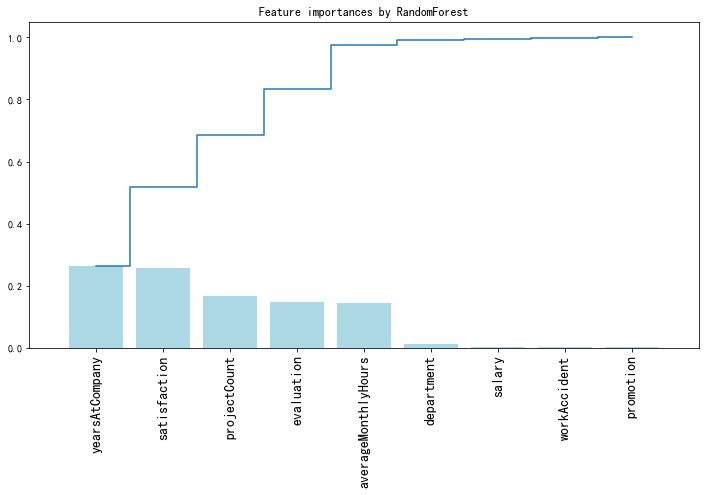

In [53]:
# 随机森林特征分析
importances = rf.feature_importances_
feature_names = data_df.drop(['turnover'], axis=1).columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature importances by RandomForest')
plt.bar(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical', fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

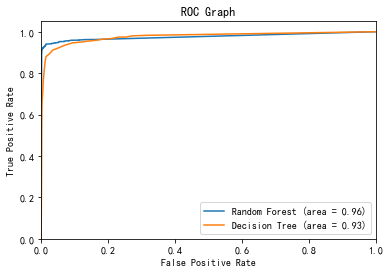

In [54]:
# ROC 
from sklearn.metrics import roc_curve
# 计算ROC曲线
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree.predict_proba(x_test)[:,1])

plt.figure()

# 随机森林 ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# 决策树 ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
# 绘图
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()